### imports. 

In [1]:
from PredCST.frames.code_frame import CodeFrame
from PredCST.utils.pythonparser import print_code_diff
from PredCST.utils.dataset_creation import add_token_count_and_drop_tokens, compute_embedding_percentage, count_python_packages, count_python_files, compute_embedding_price
import polars as pl
from typing import Union, List, Optional
import tiktoken
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('/Users/hk3user/Documents/Dev/Cynde')  
import cynde.functional as cf
import nest_asyncio

nest_asyncio.apply()
import seaborn as sns

/Users/hk3user/Documents/Dev/Cynde


In [2]:
#get openaisecret
openaisecret = os.environ.get('OPENAI_API_KEY')


### Util functions. 

### Load code frame 

In [3]:
code_repo = "./repo_list/standard_lib"
mfp = CodeFrame.from_python(
    directory_path=code_repo,
    resolution="function",
    value_column="code",
    lint_code=False,
    name="python_3_12_1_standard_lib_frame",
)
mfp.resolution="all"
mfp.df = pl.read_parquet("./saved_frames/python_standard_lib/python_3_12_1_standard_lib_base_frame")
mfp.modules = pl.read_parquet("./saved_frames/python_standard_lib/python_3_12_1_standard_lib_modules_frame")
mfp.functions = pl.read_parquet("./saved_frames/python_standard_lib/python_3_12_1_standard_lib_functions_frame")
mfp.classes = pl.read_parquet("./saved_frames/python_standard_lib/python_3_12_1_standard_lib_classes_frame")

Error processing ./repo_list/standard_lib/test/test_grammar.py: Syntax Error @ 426:31.
parser error: error at 425:30: expected one of !=, %, &, (, *, **, +, ,, -, ., /, //, ;, <, <<, <=, =, ==, >, >=, >>, @, NEWLINE, [, ^, and, if, in, is, not, or, |

            print(no_such_global)
                              ^
Error processing ./repo_list/standard_lib/test/badsyntax_pep3120.py: 'utf-8' codec can't decode byte 0xf6 in position 8: invalid start byte
Error processing ./repo_list/standard_lib/test/typinganndata/ann_module.py: Syntax Error @ 32:1.
parser error: error at 31:8: expected one of !=, %, &, (, *, **, +, ,, -, ., /, //, ;, <, <<, <=, =, ==, >, >=, >>, @, NEWLINE, [, ^, and, if, in, is, not, or, |

(pars): bool = True
                  ^
Error processing ./repo_list/standard_lib/test/tokenizedata/badsyntax_3131.py: Syntax Error @ 1:1.
tokenizer error: "€" is not a valid identifier

# -*- coding: utf-8 -*-
^
Error processing ./repo_list/standard_lib/test/encoded_modules/module

In [ ]:
packages = count_python_packages(code_repo)
pyfiles = count_python_files(code_repo)
print(f"Number of Python packages: {packages}")
print(f"Number of Python files: {pyfiles}")

Number of Python packages: 163
Number of Python files: 164


In [ ]:
mfp.df = add_token_count_and_drop_tokens(mfp.df, 'code')
mfp.df = add_token_count_and_drop_tokens(mfp.df, 'cst_tree')
print(compute_embedding_percentage(mfp.df, 'code_token_len'))
print(compute_embedding_percentage(mfp.df, 'cst_tree_token_len'))

99.50476889214967
86.77680536631381


# modules. 

### Map licenses for Python Standard Lib. 

In [4]:
license_mapping = {
    # Sockets module might use code from the WIDE Project
    "socket.py": "BSD-like License from WIDE Project",
    # Cookie management module
    "http/cookies.py": "MIT License by Timothy O'Malley",
    # Execution tracing might not directly map but relate to trace.py
    "trace.py": "PSF License with contributions under Python 2.2 license",
    # UUencode and UUdecode functions, directly applies to uu module
    "uu.py": "PSF License with acknowledgment to Lance Ellinghouse and modifications by Jack Jansen",
    # XML RPC client interface
    "xmlrpc/client.py": "MIT License by Secret Labs AB and Fredrik Lundh",
    # OpenSSL is used by several modules for encryption and security
    "ssl.py": "Apache License 2.0 (for OpenSSL components)",
    "test/support/asynchat.py":"Copyright 1996 by Sam Rushing",
    "test/support/asyncore.py":"Copyright 1996 by Sam Rushing",
    "hashlib.py": "Apache License 2.0 (for OpenSSL components)",
    "random.py": "Copyright (C) 1997 - 2002, Makoto Matsumoto and Takuji Nishimura",
    "posixpath.py": "Apache License 2.0 (for OpenSSL components)",
    "crypt.py": "Apache License 2.0 (for OpenSSL components)",
    # expat parser used in xml modules
    "xml/parsers/expat.py": "MIT License for included expat sources",
    # libmpdec is used by the decimal module
    "decimal.py": "BSD License for included libmpdec sources",
}


In [5]:
mfp.modules = (
    mfp.modules
    .with_columns(modules = pl.col("file_name").str.replace('./repo_list/standard_lib/', "", literal=True))


)
lics = ['Python Software Foundation License'] * mfp.modules.shape[0]
version =['3.12.1'] * mfp.modules.shape[0]
mfp.modules = mfp.modules.with_columns(pl.Series(name="license", values=lics))
mfp.modules = mfp.modules.with_columns(pl.Series(name="version", values=version))

for module_path, license_name in license_mapping.items():
    mfp.modules = mfp.modules.with_columns(
        pl.when(pl.col("modules") == module_path)
        .then(pl.lit(license_name))
        .otherwise(pl.col("license"))
        .alias("license_temp")
    )
    # Swap the temporary column to 'license' and drop the old 'license'
    mfp.modules = mfp.modules.drop("license").rename({"license_temp": "license"})
print(mfp.modules.shape)
mfp.modules.head(2)

(2056, 9)


type,code,cst_tree,file_name,modules,version,code_token_len,cst_tree_token_len,license
str,str,str,str,str,str,i64,i64,str
"""module""","""# SPDX-License…","""Module( bo…","""./repo_list/st…","""test/test_toml…","""3.12.1""",480,15040,"""Python Softwar…"
"""module""",""""""""" Correct sy…","""Module( bo…","""./repo_list/st…","""test/typingann…","""3.12.1""",130,3482,"""Python Softwar…"


In [6]:
total_modules = mfp.modules.shape[0]
psf_modules = mfp.modules.filter(pl.col('license') == 'Python Software Foundation License').shape[0]
psf_percentage = (psf_modules / total_modules) * 100
print(f"The percentage of modules under the 'Python Software Foundation License' is: {psf_percentage:.2f}%")


The percentage of modules under the 'Python Software Foundation License' is: 99.32%


### token counter. 

In [7]:
mfp.modules = add_token_count_and_drop_tokens(mfp.modules, 'code')
mfp.modules = add_token_count_and_drop_tokens(mfp.modules, 'cst_tree')


In [8]:
print(f"{mfp.modules.select(pl.col('code_token_len').sum())[0, 'code_token_len']:,}")
print(f"{mfp.modules.select(pl.col('cst_tree_token_len').sum())[0, 'cst_tree_token_len']:,}")


9,118,446
239,306,272


### analysis. 

In [27]:
print(compute_embedding_percentage(mfp.modules, 'code_token_len'))
print(compute_embedding_percentage(mfp.modules, 'cst_tree_token_len'))

85.84630350194551
20.379377431906615


In [17]:
print(f'{compute_embedding_price(mfp.modules, "code"):.2f}')
print(f'{compute_embedding_price(mfp.modules, "cst_tree"):.2f}')


11.85
311.10


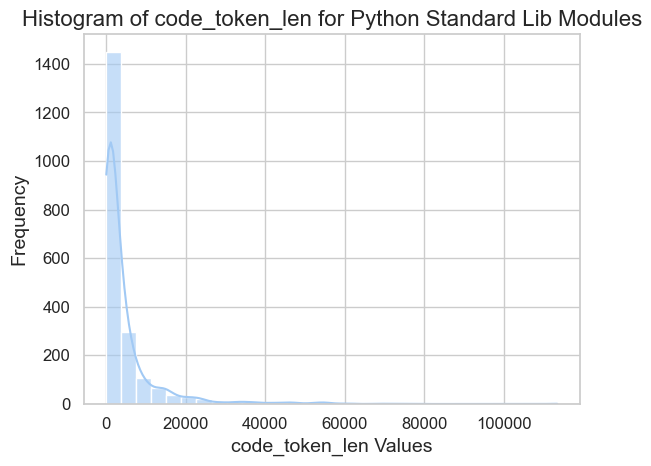

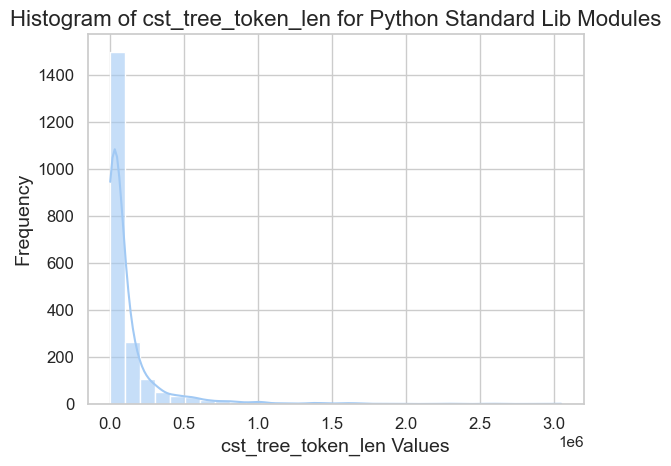

In [16]:
plot_token_len_histograms(mfp.modules, "Python Standard Lib Modules")

### Embedding

In [17]:
modules = mfp.modules.filter(pl.col("code_token_len") < 10700).filter(pl.col("code_token_len") >5)

In [14]:
modules = modules.sample(100)

In [15]:
modules.describe()

statistic,type,code,cst_tree,file_name,modules,version,license,code_token_len,cst_tree_token_len
str,str,str,str,str,str,str,str,f64,f64
"""count""","""100""","""100""","""100""","""100""","""100""","""100""","""100""",100.0,100.0
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0
"""mean""",null,null,null,null,null,null,null,1816.15,49305.95
"""std""",null,null,null,null,null,null,null,1793.213798,50167.392683
"""min""","""module""",""""""""" Define nam…","""Module( bo…","""./repo_list/st…","""asyncio/events…","""3.12.1""","""BSD License fo…",6.0,197.0
"""25%""",null,null,null,null,null,null,null,377.0,10745.0
"""50%""",null,null,null,null,null,null,null,1348.0,36472.0
"""75%""",null,null,null,null,null,null,null,2464.0,68003.0
"""max""","""module""","""try: from …","""Module( bo…","""./repo_list/st…","""wsgiref/header…","""3.12.1""","""Python Softwar…",6949.0,239728.0


In [18]:
embedded_df = cf.embed_columns(df=modules, column_names=["code"],models=["voyage-code-2"], request_url="https://api.voyageai.com/v1/embeddings", api_key=VOYAGER_API_KEY)

INFO:root:Starting request #0
INFO:root:Starting request #1
INFO:root:Starting request #2
INFO:root:Starting request #3
INFO:root:Starting request #4
INFO:root:Starting request #5
INFO:root:Starting request #6
INFO:root:Starting request #7
INFO:root:Starting request #8
INFO:root:Starting request #9
INFO:root:Starting request #10
INFO:root:Starting request #11
INFO:root:Starting request #12
INFO:root:Starting request #13
INFO:root:Starting request #14
INFO:root:Starting request #15
INFO:root:Starting request #16
INFO:root:Starting request #17
INFO:root:Starting request #18
INFO:root:Starting request #19
INFO:root:Starting request #20
INFO:root:Starting request #21
INFO:root:Starting request #22
INFO:root:Starting request #23
INFO:root:Starting request #24
INFO:root:Starting request #25
INFO:root:Starting request #26
INFO:root:Starting request #27
INFO:root:Starting request #28
INFO:root:Starting request #29
INFO:root:Starting request #30
INFO:root:Starting request #31


generate_embedding_batched_payloads_from_column took 0.07894866700007697 minutes/seconds


INFO:root:Starting request #32
INFO:root:Starting request #33
INFO:root:Starting request #34
INFO:root:Starting request #35
INFO:root:Starting request #36
INFO:root:Starting request #37
INFO:root:Starting request #38
INFO:root:Starting request #39
INFO:root:Starting request #40
INFO:root:Starting request #41
INFO:root:Starting request #42
INFO:root:Starting request #43
INFO:root:Starting request #44
INFO:root:Starting request #45
INFO:root:Starting request #46
INFO:root:Starting request #47
INFO:root:Starting request #48
INFO:root:Starting request #49
INFO:root:Starting request #50
INFO:root:Starting request #51
INFO:root:Starting request #52
INFO:root:Starting request #53
INFO:root:Starting request #54
INFO:root:Starting request #55
INFO:root:Starting request #56
INFO:root:Starting request #57
INFO:root:Starting request #58
INFO:root:Starting request #59
INFO:root:Starting request #60
INFO:root:Starting request #61
INFO:root:Starting request #62
INFO:root:Starting request #63
INFO:roo

process_api_requests_from_file took 186.59504112500144 minutes/seconds
load_openai_batched_emb_results_jsonl took 0.33699450000131037 minutes/seconds
merge_df_with_openai_emb_results took 0.010451209000166273 minutes/seconds
Embeddings for column 'code' with model 'voyage-code-2' have been merged into the DataFrame.


In [7]:
embedded_df

type,code,cst_tree,file_name,modules,version,license,code_token_len,cst_tree_token_len,code_voyage-code-2_embedding
str,str,str,str,str,str,str,i64,i64,list[f64]
"""module""","""from . import …","""Module( bo…","""./repo_list/st…","""test/test_ttk/…","""3.12.1""","""Python Softwar…",12,623,"[-0.013881, 0.024701, … -0.026663]"
"""module""","""from test.test…","""Module( bo…","""./repo_list/st…","""test/test_json…","""3.12.1""","""Python Softwar…",628,4263,"[-0.036047, 0.001462, … -0.006384]"
"""module""","""import io impo…","""Module( bo…","""./repo_list/st…","""test/test_shle…","""3.12.1""","""Python Softwar…",4023,78322,"[-0.017947, 0.020763, … -0.025575]"
"""module""","""# tests common…","""Module( bo…","""./repo_list/st…","""test/mapping_t…","""3.12.1""","""Python Softwar…",5272,222988,"[-0.031307, -0.010623, … -0.03535]"
"""module""","""import asyncio…","""Module( bo…","""./repo_list/st…","""test/test_unit…","""3.12.1""","""Python Softwar…",8139,297629,"[-0.008407, 0.01007, … -0.014724]"
…,…,…,…,…,…,…,…,…,…
"""module""","""""""""Token const…","""Module( bo…","""./repo_list/st…","""token.py""","""3.12.1""","""Python Softwar…",947,23633,"[-0.011044, 0.003179, … -0.032832]"
"""module""","""import webbrow…","""Module( bo…","""./repo_list/st…","""test/test_webb…","""3.12.1""","""Python Softwar…",2115,79791,"[-0.021098, 0.014917, … -0.019671]"
"""module""","""r"""""" This test…","""Module( bo…","""./repo_list/st…","""test/test_ctyp…","""3.12.1""","""Python Softwar…",453,3552,"[-0.012802, 0.003362, … -0.038994]"


In [19]:
embedded_df.write_parquet("./saved_frames/Voyager_python_3_12_1_standard_lib_modules_embedded_code.parquet")

In [20]:
embedded_df = pl.read_parquet("./saved_frames/Voyager_python_3_12_1_standard_lib_modules_embedded_code.parquet")

In [21]:
embedded_df

type,code,cst_tree,file_name,modules,version,license,code_token_len,cst_tree_token_len,code_voyage-code-2_embedding
str,str,str,str,str,str,str,i64,i64,list[f64]
"""module""","""# SPDX-License…","""Module( bo…","""./repo_list/st…","""test/test_toml…","""3.12.1""","""Python Softwar…",480,15040,"[-0.008709, 0.003747, … -0.005842]"
"""module""",""""""""" Correct sy…","""Module( bo…","""./repo_list/st…","""test/typingann…","""3.12.1""","""Python Softwar…",130,3482,"[-0.008644, -0.003279, … -0.012194]"
"""module""","""import os impo…","""Module( bo…","""./repo_list/st…","""test/test_ctyp…","""3.12.1""","""Python Softwar…",1118,28613,"[-0.03387, 0.044845, … -0.002814]"
"""module""","""import unittes…","""Module( bo…","""./repo_list/st…","""test/test_capi…","""3.12.1""","""Python Softwar…",86,2852,"[-0.015083, 0.016645, … -0.014105]"
"""module""","""from math impo…","""Module( bo…","""./repo_list/st…","""test/test_capi…","""3.12.1""","""Python Softwar…",2390,74214,"[-0.035045, -0.000836, … -0.003078]"
…,…,…,…,…,…,…,…,…,…
"""module""","""import logging…","""Module( bo…","""./repo_list/st…","""site-packages/…","""3.12.1""","""Python Softwar…",1323,44550,"[-0.014442, 0.04387, … -0.040119]"
"""module""",""""""""" pygmen…","""Module( bo…","""./repo_list/st…","""site-packages/…","""3.12.1""","""Python Softwar…",1194,36994,"[0.004227, 0.023489, … -0.054453]"
"""module""","""# exceptions.p…","""Module( bo…","""./repo_list/st…","""site-packages/…","""3.12.1""","""Python Softwar…",2074,45052,"[-0.009378, 0.005666, … -0.020345]"


# functions. 

### Map licenses for Python Standard Lib. 

In [39]:
mfp.functions = (
    mfp.functions
    .with_columns(modules = pl.col("file_name").str.replace('./repo_list/standard_lib/', "", literal=True))


)
lics = ['Python Software Foundation License'] * mfp.functions.shape[0]
version =['3.12.1'] * mfp.functions.shape[0]
mfp.functions = mfp.functions.with_columns(pl.Series(name="license", values=lics))
mfp.functions = mfp.functions.with_columns(pl.Series(name="version", values=version))

for module_path, license_name in license_mapping.items():
    mfp.functions = mfp.functions.with_columns(
        pl.when(pl.col("modules") == module_path)
        .then(pl.lit(license_name))
        .otherwise(pl.col("license"))
        .alias("license_temp")
    )
    # Swap the temporary column to 'license' and drop the old 'license'
    mfp.functions = mfp.functions.drop("license").rename({"license_temp": "license"})
print(mfp.functions.shape)
mfp.functions.head(2)

(61009, 9)


type,code,cst_tree,file_name,modules,version,code_token_len,cst_tree_token_len,license
str,str,str,str,str,str,i64,i64,str
"""function""",""" def __init__(…","""FunctionDef( …","""./repo_list/st…","""tempfile.py""","""3.12.1""",47,1743,"""Python Softwar…"
"""function""",""" # The underly…","""FunctionDef( …","""./repo_list/st…","""tempfile.py""","""3.12.1""",42,841,"""Python Softwar…"


### token counter. 

In [21]:
mfp.functions = add_token_count_and_drop_tokens(mfp.functions, 'code')
mfp.functions = add_token_count_and_drop_tokens(mfp.functions, 'cst_tree')


In [25]:
print(f"{mfp.functions.select(pl.col('code_token_len').sum())[0, 'code_token_len']:,}")
print(f"{mfp.functions.select(pl.col('cst_tree_token_len').sum())[0, 'cst_tree_token_len']:,}")

6,977,330
210,537,222


### Analysis. 

In [26]:
print(compute_embedding_percentage(mfp.functions, 'code_token_len'))
print(compute_embedding_percentage(mfp.functions, 'cst_tree_token_len'))

100.0
91.87333016440198


In [18]:
print(f'{compute_embedding_price(mfp.functions, "code"):.2f}')
print(f'{compute_embedding_price(mfp.functions, "cst_tree"):.2f}')

9.07
273.70


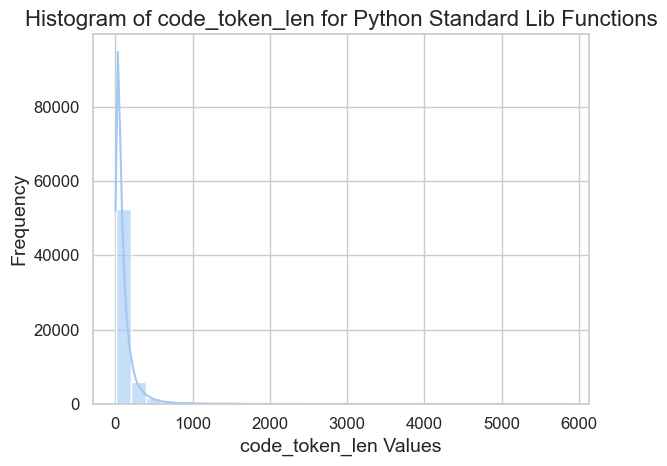

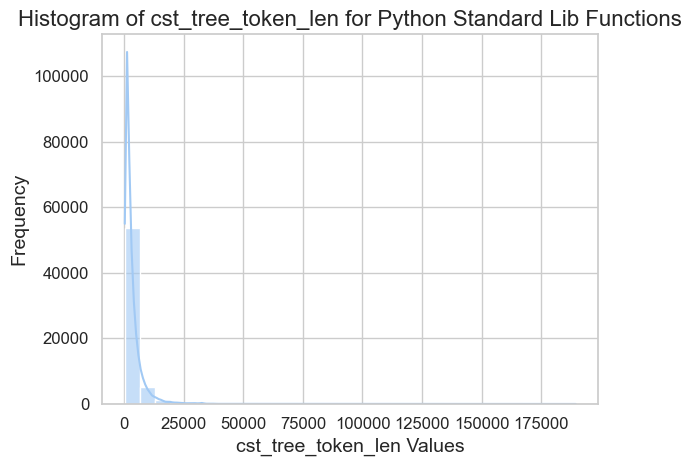

In [17]:
plot_token_len_histograms(mfp.functions,"Python Standard Lib Functions")

### Embedding

In [30]:
functions = mfp.functions.filter(pl.col("code_token_len") <10700).filter(pl.col("code_token_len") >5)

In [34]:
functions = functions.unique(subset='code')

In [35]:
functions

type,code,cst_tree,file_name,modules,version,license,code_token_len,cst_tree_token_len
str,str,str,str,str,str,str,i64,i64
"""function""",""" def _get_deco…","""FunctionDef( …","""./repo_list/st…","""_pyio.py""","""3.12.1""","""Python Softwar…",76,2441
"""function""",""" @property def…","""FunctionDef( …","""./repo_list/st…","""test/test_prop…","""3.12.1""","""Python Softwar…",19,632
"""function""",""" def test_int_…","""FunctionDef( …","""./repo_list/st…","""test/test_ctyp…","""3.12.1""","""Python Softwar…",153,4804
"""function""",""" def joinpath(…","""FunctionDef( …","""./repo_list/st…","""test/test_getp…","""3.12.1""","""Python Softwar…",22,946
"""function""",""" def iterdir(s…","""FunctionDef( …","""./repo_list/st…","""importlib/reso…","""3.12.1""","""Python Softwar…",10,613
…,…,…,…,…,…,…,…,…
"""function""",""" def pack_fstr…","""FunctionDef( …","""./repo_list/st…","""xdrlib.py""","""3.12.1""","""Python Softwar…",77,2669
"""function""",""" # The deepcop…","""FunctionDef( …","""./repo_list/st…","""test/test_copy…","""3.12.1""","""Python Softwar…",34,1317
"""function""",""" def __init__(…","""FunctionDef( …","""./repo_list/st…","""selectors.py""","""3.12.1""","""Python Softwar…",16,675


In [23]:
embedded_df = cf.embed_columns(df=functions, column_names=["code"],models=["voyage-code-2"], request_url="https://api.voyageai.com/v1/embeddings", api_key=VOYAGER_API_KEY)

INFO:root:Starting request #0
INFO:root:Starting request #1
INFO:root:Starting request #2
INFO:root:Starting request #3
INFO:root:Starting request #4
INFO:root:Starting request #5
INFO:root:Starting request #6
INFO:root:Starting request #7
INFO:root:Starting request #8
INFO:root:Starting request #9
INFO:root:Starting request #10
INFO:root:Starting request #11
INFO:root:Starting request #12
INFO:root:Starting request #13
INFO:root:Starting request #14
INFO:root:Starting request #15
INFO:root:Starting request #16
INFO:root:Starting request #17
INFO:root:Starting request #18
INFO:root:Starting request #19
INFO:root:Starting request #20
INFO:root:Starting request #21
INFO:root:Starting request #22
INFO:root:Starting request #23
INFO:root:Starting request #24
INFO:root:Starting request #25
INFO:root:Starting request #26
INFO:root:Starting request #27
INFO:root:Starting request #28
INFO:root:Starting request #29
INFO:root:Starting request #30
INFO:root:Starting request #31
INFO:root:Starting

generate_embedding_batched_payloads_from_column took 0.2584317920009198 minutes/seconds


INFO:root:Starting request #100
INFO:root:Starting request #101
INFO:root:Starting request #102
INFO:root:Starting request #103
INFO:root:Starting request #104
INFO:root:Starting request #105
INFO:root:Starting request #106
INFO:root:Starting request #107
INFO:root:Starting request #108
INFO:root:Starting request #109
INFO:root:Starting request #110
INFO:root:Starting request #111
INFO:root:Starting request #112
INFO:root:Starting request #113
INFO:root:Starting request #114
INFO:root:Starting request #115
INFO:root:Starting request #116
INFO:root:Starting request #117
INFO:root:Starting request #118
INFO:root:Starting request #119
INFO:root:Starting request #120
INFO:root:Starting request #121
INFO:root:Starting request #122
INFO:root:Starting request #123
INFO:root:Starting request #124
INFO:root:Starting request #125
INFO:root:Starting request #126
INFO:root:Starting request #127
INFO:root:Starting request #128
INFO:root:Starting request #129
INFO:root:Starting request #130
INFO:roo

process_api_requests_from_file took 7241.770992500002 minutes/seconds
load_openai_batched_emb_results_jsonl took 11.516703791003238 minutes/seconds
merge_df_with_openai_emb_results took 4.8009240829997 minutes/seconds
Embeddings for column 'code' with model 'voyage-code-2' have been merged into the DataFrame.


In [27]:
embedded_df = embedded_df.unique(subset='code')
embedded_df

type,code,cst_tree,file_name,modules,version,license,code_token_len,cst_tree_token_len,code_voyage-code-2_embedding
str,str,str,str,str,str,str,i64,i64,list[f64]
"""function""",""" def manipulat…","""FunctionDef( …","""./repo_list/st…","""test/test_impo…","""3.12.1""","""Python Softwar…",203,6687,"[-0.03257, 0.000353, … -0.008823]"
"""function""",""" def prepare_a…","""FunctionDef( …","""./repo_list/st…","""site-packages/…","""3.12.1""","""Python Softwar…",155,4186,"[-0.022781, 0.010564, … -0.050697]"
"""function""",""" def ipy_show_…","""FunctionDef( …","""./repo_list/st…","""site-packages/…","""3.12.1""","""Python Softwar…",62,1315,"[-0.011175, 0.060013, … -0.03416]"
"""function""",""" @property def…","""FunctionDef( …","""./repo_list/st…","""ipaddress.py""","""3.12.1""","""Python Softwar…",57,746,"[-0.01085, -0.00376, … -0.035895]"
"""function""","""async def gen(…","""FunctionDef( …","""./repo_list/st…","""test/test_asyn…","""3.12.1""","""Python Softwar…",14,474,"[-0.004724, 0.00093, … -0.0026]"
…,…,…,…,…,…,…,…,…,…
"""function""",""" def __str__(s…","""FunctionDef( …","""./repo_list/st…","""test/test_sqli…","""3.12.1""","""Python Softwar…",17,601,"[0.002885, -0.005575, … -0.031828]"
"""function""",""" def test_togg…","""FunctionDef( …","""./repo_list/st…","""idlelib/idle_t…","""3.12.1""","""Python Softwar…",256,8182,"[-0.027856, 0.035437, … -0.035085]"
"""function""",""" def test_erro…","""FunctionDef( …","""./repo_list/st…","""test/test_http…","""3.12.1""","""Python Softwar…",143,4980,"[-0.017347, -0.004411, … -0.02537]"


In [28]:
embedded_df.write_parquet("./saved_frames/Voyager_python_3_12_1_standard_lib_functions_embedded_code.parquet")

In [29]:
embedded_df

type,code,cst_tree,file_name,modules,version,license,code_token_len,cst_tree_token_len,code_voyage-code-2_embedding
str,str,str,str,str,str,str,i64,i64,list[f64]
"""function""",""" def manipulat…","""FunctionDef( …","""./repo_list/st…","""test/test_impo…","""3.12.1""","""Python Softwar…",203,6687,"[-0.03257, 0.000353, … -0.008823]"
"""function""",""" def prepare_a…","""FunctionDef( …","""./repo_list/st…","""site-packages/…","""3.12.1""","""Python Softwar…",155,4186,"[-0.022781, 0.010564, … -0.050697]"
"""function""",""" def ipy_show_…","""FunctionDef( …","""./repo_list/st…","""site-packages/…","""3.12.1""","""Python Softwar…",62,1315,"[-0.011175, 0.060013, … -0.03416]"
"""function""",""" @property def…","""FunctionDef( …","""./repo_list/st…","""ipaddress.py""","""3.12.1""","""Python Softwar…",57,746,"[-0.01085, -0.00376, … -0.035895]"
"""function""","""async def gen(…","""FunctionDef( …","""./repo_list/st…","""test/test_asyn…","""3.12.1""","""Python Softwar…",14,474,"[-0.004724, 0.00093, … -0.0026]"
…,…,…,…,…,…,…,…,…,…
"""function""",""" def __str__(s…","""FunctionDef( …","""./repo_list/st…","""test/test_sqli…","""3.12.1""","""Python Softwar…",17,601,"[0.002885, -0.005575, … -0.031828]"
"""function""",""" def test_togg…","""FunctionDef( …","""./repo_list/st…","""idlelib/idle_t…","""3.12.1""","""Python Softwar…",256,8182,"[-0.027856, 0.035437, … -0.035085]"
"""function""",""" def test_erro…","""FunctionDef( …","""./repo_list/st…","""test/test_http…","""3.12.1""","""Python Softwar…",143,4980,"[-0.017347, -0.004411, … -0.02537]"


# classes. 

### mapping licenses for Python Standard Live. 

In [56]:
mfp.classes = (
    mfp.classes
    .with_columns(modules = pl.col("file_name").str.replace('./repo_list/standard_lib/', "", literal=True))


)
lics = ['Python Software Foundation License'] * mfp.classes.shape[0]
version =['3.12.1'] * mfp.classes.shape[0]
mfp.classes = mfp.classes.with_columns(pl.Series(name="license", values=lics))
mfp.classes = mfp.classes.with_columns(pl.Series(name="version", values=version))

for module_path, license_name in license_mapping.items():
    mfp.classes = mfp.classes.with_columns(
        pl.when(pl.col("modules") == module_path)
        .then(pl.lit(license_name))
        .otherwise(pl.col("license"))
        .alias("license_temp")
    )
    # Swap the temporary column to 'license' and drop the old 'license'
    mfp.classes = mfp.classes.drop("license").rename({"license_temp": "license"})
print(mfp.classes.shape)
mfp.classes.head(2)

(13263, 9)


type,code,cst_tree,file_name,modules,version,code_token_len,cst_tree_token_len,license
str,str,str,str,str,str,i64,i64,str
"""class""",""" class Windows…","""ClassDef( …","""./repo_list/st…","""webbrowser.py""","""3.12.1""",82,2325,"""Python Softwar…"
"""class""",""" class NNTPPe…","""ClassDef( …","""./repo_list/st…","""nntplib.py""","""3.12.1""",20,567,"""Python Softwar…"


### token counter. 

In [19]:
mfp.classes = add_token_count_and_drop_tokens(mfp.classes, 'code')
mfp.classes = add_token_count_and_drop_tokens(mfp.classes, 'cst_tree')




In [26]:
print(f"{mfp.classes.select(pl.col('code_token_len').sum())[0, 'code_token_len']:,}")
print(f"{mfp.classes.select(pl.col('cst_tree_token_len').sum())[0, 'cst_tree_token_len']:,}")

6,273,348
190,318,938


### Analysis. 

In [25]:
print(compute_embedding_percentage(mfp.classes, 'code_token_len'))
print(compute_embedding_percentage(mfp.classes, 'cst_tree_token_len'))


99.33650003769885
73.62587649852973


In [20]:
print(f'{compute_embedding_price(mfp.classes, "code"):.2f}')
print(f'{compute_embedding_price(mfp.classes, "cst_tree"):.2f}')

8.15
247.21


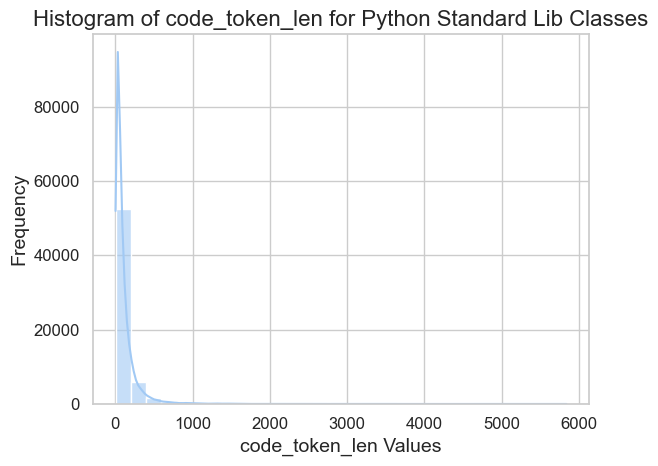

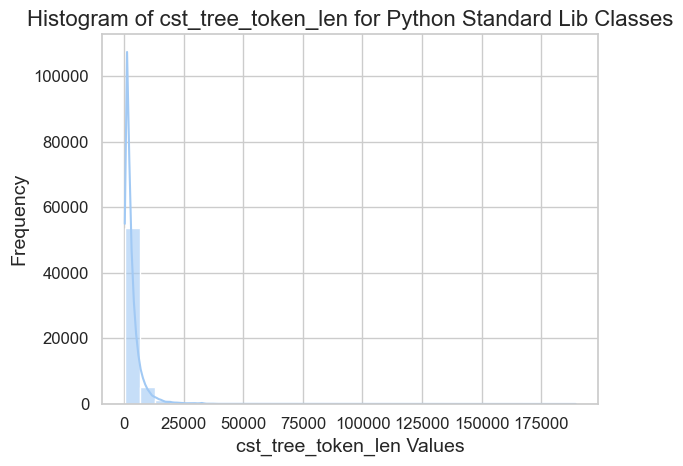

In [18]:
plot_token_len_histograms(mfp.functions,"Python Standard Lib Classes")


### Embedding

In [51]:
classes = mfp.classes.filter(pl.col("code_token_len") <10_700).filter(pl.col("code_token_len") >5)

In [52]:
classes = classes.unique(subset='code')

In [50]:
classes

type,code,cst_tree,file_name,modules,version,license,code_token_len,cst_tree_token_len
str,str,str,str,str,str,str,i64,i64
"""class""","""class Foo(unit…","""ClassDef( …","""./repo_list/st…","""test/test_unit…","""3.12.1""","""Python Softwar…",20,891
"""class""",""" class Contai…","""ClassDef( …","""./repo_list/st…","""test/test_unit…","""3.12.1""","""Python Softwar…",81,4043
"""class""",""" class Compar…","""ClassDef( …","""./repo_list/st…","""test/test_ipad…","""3.12.1""","""Python Softwar…",1939,60412
"""class""",""" class Messag…","""ClassDef( …","""./repo_list/st…","""email/errors.p…","""3.12.1""","""Python Softwar…",17,462
"""class""",""" # Internal i…","""ClassDef( …","""./repo_list/st…","""typing.py""","""3.12.1""","""Python Softwar…",309,10441
…,…,…,…,…,…,…,…,…
"""class""",""" class MultiC…","""ClassDef( …","""./repo_list/st…","""idlelib/idle_t…","""3.12.1""","""Python Softwar…",272,9373
"""class""",""" class MiscRe…","""ClassDef( …","""./repo_list/st…","""test/test_tarf…","""3.12.1""","""Python Softwar…",2732,91764
"""class""",""" class Opera(…","""ClassDef( …","""./repo_list/st…","""webbrowser.py""","""3.12.1""","""Python Softwar…",53,1409


In [53]:
embedded_df = cf.embed_columns(df=classes, column_names=["code"],models=["voyage-code-2"], request_url="https://api.voyageai.com/v1/embeddings", api_key=VOYAGER_API_KEY)

INFO:root:Starting request #0
INFO:root:Starting request #1
INFO:root:Starting request #2
INFO:root:Starting request #3
INFO:root:Starting request #4
INFO:root:Starting request #5
INFO:root:Starting request #6
INFO:root:Starting request #7
INFO:root:Starting request #8
INFO:root:Starting request #9
INFO:root:Starting request #10
INFO:root:Starting request #11
INFO:root:Starting request #12
INFO:root:Starting request #13
INFO:root:Starting request #14
INFO:root:Starting request #15
INFO:root:Starting request #16
INFO:root:Starting request #17
INFO:root:Starting request #18
INFO:root:Starting request #19
INFO:root:Starting request #20
INFO:root:Starting request #21
INFO:root:Starting request #22
INFO:root:Starting request #23
INFO:root:Starting request #24
INFO:root:Starting request #25
INFO:root:Starting request #26
INFO:root:Starting request #27
INFO:root:Starting request #28
INFO:root:Starting request #29
INFO:root:Starting request #30
INFO:root:Starting request #31
INFO:root:Starting

generate_embedding_batched_payloads_from_column took 0.1566108750012063 minutes/seconds


INFO:root:Starting request #88
INFO:root:Starting request #89
INFO:root:Starting request #90
INFO:root:Starting request #91
INFO:root:Starting request #92
INFO:root:Starting request #93
INFO:root:Starting request #94
INFO:root:Starting request #95
INFO:root:Starting request #96
INFO:root:Starting request #97
INFO:root:Starting request #98
INFO:root:Starting request #99
INFO:root:Starting request #100
INFO:root:Starting request #101
INFO:root:Starting request #102
INFO:root:Starting request #103
INFO:root:Starting request #104
INFO:root:Starting request #105
INFO:root:Starting request #106
INFO:root:Starting request #107
INFO:root:Starting request #108
INFO:root:Starting request #109
INFO:root:Starting request #110
INFO:root:Starting request #111
INFO:root:Starting request #112
INFO:root:Starting request #113
INFO:root:Starting request #114
INFO:root:Starting request #115
INFO:root:Starting request #116
INFO:root:Starting request #117
INFO:root:Starting request #118
INFO:root:Starting r

process_api_requests_from_file took 1436.915951250001 minutes/seconds
load_openai_batched_emb_results_jsonl took 2.7437373749999097 minutes/seconds
merge_df_with_openai_emb_results took 0.06964795800013235 minutes/seconds
Embeddings for column 'code' with model 'voyage-code-2' have been merged into the DataFrame.


In [56]:
embedded_df = embedded_df.unique(subset='code')
embedded_df

type,code,cst_tree,file_name,modules,version,license,code_token_len,cst_tree_token_len,code_voyage-code-2_embedding
str,str,str,str,str,str,str,i64,i64,list[f64]
"""class""",""" class _Asser…","""ClassDef( …","""./repo_list/st…","""unittest/case.…","""3.12.1""","""Python Softwar…",323,8918,"[-0.018487, 0.0421, … -0.007803]"
"""class""",""" class MyHandl…","""ClassDef( …","""./repo_list/st…","""test/test_sock…","""3.12.1""","""Python Softwar…",13,466,"[-0.033775, -0.0015, … -0.041934]"
"""class""",""" class Invali…","""ClassDef( …","""./repo_list/st…","""email/errors.p…","""3.12.1""","""Python Softwar…",22,466,"[-0.025827, 0.010227, … -0.009758]"
"""class""",""" class ProxyT…","""ClassDef( …","""./repo_list/st…","""test/test_urll…","""3.12.1""","""Python Softwar…",735,23365,"[-0.00962, 0.005748, … -0.022946]"
"""class""",""" class C(objec…","""ClassDef( …","""./repo_list/st…","""test/test_desc…","""3.12.1""","""Python Softwar…",19,681,"[-0.021196, 0.015184, … -0.037714]"
…,…,…,…,…,…,…,…,…,…
"""class""",""" class MySSLOb…","""ClassDef( …","""./repo_list/st…","""test/test_ssl.…","""3.12.1""","""Python Softwar…",14,465,"[-0.024228, -0.016916, … -0.042604]"
"""class""",""" class evp_En…","""ClassDef( …","""./repo_list/st…","""test/test_lib2…","""3.12.1""","""Python Softwar…",15,435,"[-0.034173, -0.012794, … -0.008259]"
"""class""",""" class Stream…","""ClassDef( …","""./repo_list/st…","""site-packages/…","""3.12.1""","""Python Softwar…",419,10694,"[-0.012057, 0.026504, … -0.055687]"


In [55]:
embedded_df.write_parquet("./saved_frames/Voyager_python_3_12_1_standard_lib_classes_embedded_code.parquet")


In [ ]:
embedded_df

# All

In [6]:
m = pl.read_parquet("python_3_12_1_standard_lib_modules_all.parquet")
f =pl.read_parquet("python_3_12_1_standard_lib_functions_all.parquet")
c =pl.read_parquet("python_3_12_1_standard_lib_classes_all.parquet")


In [27]:
a = pl.concat([m, f, c])

In [29]:
a.write_parquet("python_3_12_1_standard_lib_all.parquet")

In [4]:
mfp.df = pl.read_parquet("python_3_12_1_standard_lib_all.parquet")
mfp.modules = pl.read_parquet("python_3_12_1_standard_lib_modules_all.parquet")
mfp.functions = pl.read_parquet("python_3_12_1_standard_lib_functions_all.parquet")
mfp.classes = pl.read_parquet("python_3_12_1_standard_lib_classes_all.parquet")

# Counters

In [9]:
mfp.df.head(1)

type,code,cst_tree,file_name,modules,version,license,code_token_len,cst_tree_token_len,code_text-embedding-3-small_embedding,code_text-embedding-3-large_embedding,cst_tree_text-embedding-3-small_embedding
str,str,str,str,str,str,str,i64,i64,list[f64],list[f64],list[f64]
"""module""","""# Used by test…","""Module( bo…","""./repo_list/st…","""test/typingann…","""3.12.1""","""Python Softwar…",49,1410,"[0.010098, 0.009077, … 0.023405]","[-0.002089, 0.011562, … -0.009838]","[-0.00099, 0.013922, … -0.012896]"


In [5]:
df = mfp.count_node_types(column_name="code")

Processing codes: 100%|██████████| 83708/83708 [05:41<00:00, 245.15it/s]


In [7]:
mfp.df = df

In [8]:
df2 = mfp.count_operators("code")

Processing codes: 100%|██████████| 83708/83708 [05:33<00:00, 251.10it/s] 


In [11]:
df2.write_parquet("python_3_12_1_standard_lib_all_with_counts.parquet")

In [88]:
df = pl.read_parquet("saved_frames/python_3_12_1_standard_lib_all_with_counts.parquet")

In [9]:
df.select(pl.col(pl.Int64)).describe()

statistic,code_token_len,cst_tree_token_len,FunctionCall,Argument,Import,If,BaseCompoundStatement,For,While,Try,With,Lambda,Global,Nonlocal,ListComprehension,DictComprehension,SetComprehension,GeneratorExpression,Yield,Await,Return,Break,Continue,Raise,Assert,Pass,BitInvert,UnaryMinus,Not,UnaryPlus,And,Or,Add,BitAnd,BitOr,BitXor,Divide,FloorDivide,LeftShift,MatrixMultiply,Modulo,Multiply,Power,RightShift,Subtract,Equal,GreaterThan,GreaterThanEqual,In,Is,LessThan,LessThanEqual,NotEqual,IsNot,NotIn,AddAssign,SubtractAssign,MultiplyAssign,DivideAssign,ModuloAssign,AndAssign,OrAssign,XorAssign,LeftShiftAssign,RightShiftAssign,PowerAssign,FloorDivideAssign,MatrixMultiplyAssign,Colon,Comma,Dot
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0,83708.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",387.955488,11170.282494,17.859667,4.850851,0.329061,1.725176,0.0,0.554678,0.070603,0.34262,0.690472,0.095534,0.010095,0.019855,0.091067,0.008984,0.004671,0.055013,0.110527,0.089107,1.270775,0.055096,0.050234,0.352212,0.084066,0.274657,0.008673,0.0,0.307044,0.0,0.244158,0.138111,0.668263,0.037201,0.07151,0.008888,0.077627,0.029125,0.026819,0.000765,0.290056,0.272531,0.067604,0.007896,0.17972,0.440854,0.08354,0.053113,0.165349,0.21581,0.092309,0.055562,0.112976,0.16898,0.056566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.393355,20.971747,20.721604
"""std""",1676.998013,46675.925886,81.31761,18.417464,2.000057,8.692726,0.0,2.957306,0.504187,1.951573,4.806321,1.054768,0.167213,0.299589,0.72117,0.158663,0.103528,0.476422,1.407029,1.931955,6.065356,0.448873,0.435443,2.134467,1.500751,2.692056,0.363653,0.0,1.664999,0.0,2.016276,0.956159,4.40792,0.587685,1.538931,0.287676,1.495489,0.398832,0.565205,0.041469,2.009289,2.49476,1.340785,0.284763,1.59362,2.779895,0.694761,0.545359,1.095478,1.485811,0.776165,0.641437,0.77978,1.109792,0.445149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.939913,141.451847,89.758329
"""min""",6.0,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",35.0,1189.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
"""50%""",83.0,2632.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0
"""75%""",240.0,7457.0,12.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [51]:
index = [i for i in range(df.shape[0])]
df = df.with_columns(pl.Series(name="index", values=index))

In [52]:
print(df.shape)
df.head(0)

(83708, 82)


type,code,cst_tree,file_name,modules,version,license,code_token_len,cst_tree_token_len,code_text-embedding-3-small_embedding,code_text-embedding-3-large_embedding,cst_tree_text-embedding-3-small_embedding,FunctionCall,Argument,Import,If,BaseCompoundStatement,For,While,Try,With,Lambda,Global,Nonlocal,ListComprehension,DictComprehension,SetComprehension,GeneratorExpression,Yield,Await,Return,Break,Continue,Raise,Assert,Pass,BitInvert,…,BitXor,Divide,FloorDivide,LeftShift,MatrixMultiply,Modulo,Multiply,Power,RightShift,Subtract,Equal,GreaterThan,GreaterThanEqual,In,Is,LessThan,LessThanEqual,NotEqual,IsNot,NotIn,AddAssign,SubtractAssign,MultiplyAssign,DivideAssign,ModuloAssign,AndAssign,OrAssign,XorAssign,LeftShiftAssign,RightShiftAssign,PowerAssign,FloorDivideAssign,MatrixMultiplyAssign,Colon,Comma,Dot,index
str,str,str,str,str,str,str,i64,i64,list[f64],list[f64],list[f64],i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64


In [53]:
count_list = []
for col in df.columns:
    if col in ['code_token_len', 'cst_tree_token_len']:
        continue

    if isinstance(df[col].dtype, pl.Int64):
        prob = df[col].gt(0).sum() / len(df)
        
        #print(f"Probability of non-zero count in column {col}: {prob}")
        #max_row = df.sort(pl.col(col)).tail(1)['code'].to_list()[0]
        #print(max_row)
        #print(f"Probability of over 10 count in column {col}: {df[col].gt(10).sum() / len(df)}")
        #print(f"Skewness of column {col}: {}")
        skew = df[col].skew()
        count_list.append({'column':col, "count": df[col].gt(0).sum(),"prob_of_non_zero":prob, 'skew': skew})




In [54]:
counts = pl.DataFrame(count_list)

In [6]:
pl.Config.set_tbl_rows(69)

polars.config.Config

Okay, so essentially I want to be able to create a method that takes in the data frame and is able to create a data set for a given node type. So we're going to give a size of the data frame, for example, 6,000. And for half of that, 50% of that, we're going to sample from the node type, the target node type. For the other 50%, we're going to look through all the other columns that are above, say 2,000 count. And we're going to sample uniformly at first. then relative to the count later. nodes or rows from the different node types that do not include the target node. So for example if the target node type is if we sample 3,000 for the 50% of rows with the if node in it. Then for the other 3,000 we'll look say we go to the return type. We want to look for all we want to look for you know some uniform number save a hundred it's probably off but a hundred rows that have the return node in it that do not have if in it 


# Action Plan for Coding:
1. Create a method that takes in the data frame and a size parameter.
2. For the first half of the size, sample from the target node type.
3. For the second half of the size, sample from all other columns with a count above a certain threshold.
4. Initially, sample uniformly. Later, sample relative to the count.
5. Exclude rows with the target node type from the second half of the size.
6. For example, if the target node type is 'if', sample 50% of the rows with 'if' and 50% of the rows with other node types.
7. For the second half of the size, sample a uniform number of rows from each node type that do not include the target node.
8. The uniform number can be adjusted based on the count of each node type.
9. This method will create a balanced dataset for the target node type and a diverse dataset for the other node types.

In [55]:
node_list = counts.filter(pl.col("count").gt(1900))

In [56]:
df.head(0)

type,code,cst_tree,file_name,modules,version,license,code_token_len,cst_tree_token_len,code_text-embedding-3-small_embedding,code_text-embedding-3-large_embedding,cst_tree_text-embedding-3-small_embedding,FunctionCall,Argument,Import,If,BaseCompoundStatement,For,While,Try,With,Lambda,Global,Nonlocal,ListComprehension,DictComprehension,SetComprehension,GeneratorExpression,Yield,Await,Return,Break,Continue,Raise,Assert,Pass,BitInvert,…,BitXor,Divide,FloorDivide,LeftShift,MatrixMultiply,Modulo,Multiply,Power,RightShift,Subtract,Equal,GreaterThan,GreaterThanEqual,In,Is,LessThan,LessThanEqual,NotEqual,IsNot,NotIn,AddAssign,SubtractAssign,MultiplyAssign,DivideAssign,ModuloAssign,AndAssign,OrAssign,XorAssign,LeftShiftAssign,RightShiftAssign,PowerAssign,FloorDivideAssign,MatrixMultiplyAssign,Colon,Comma,Dot,index
str,str,str,str,str,str,str,i64,i64,list[f64],list[f64],list[f64],i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64


In [ ]:
df2 = df.drop(['type', 'code', 'type',

 'cst_tree',
 'file_name',
 'modules',
 'version',
 'license',
 'code_token_len',
 'cst_tree_token_len',
 'code_text-embedding-3-small_embedding',
 'code_text-embedding-3-large_embedding',
 'cst_tree_text-embedding-3-small_embedding'])
df2

In [58]:
for column in df2.columns:
    if isinstance(df2[column].dtype,pl.Int64) and column != 'index':
        df2 = df2.with_columns((pl.col(column) > 0).alias(column))


In [86]:
import polars as pl
import math
from time import perf_counter

def create_dataset(df, ds_size, target_node, node_list):
    
    df_ = df.drop(['type', 'code', 'type',
        'cst_tree',
        'file_name',
        'modules',
        'version',
        'license',
        'code_token_len',
        'cst_tree_token_len',
        'code_text-embedding-3-small_embedding',
        'code_text-embedding-3-large_embedding',
        'cst_tree_text-embedding-3-small_embedding'])
    for column in df_.columns:
        if isinstance(df_[column].dtype,pl.Int64) and column != 'index':
            df_ = df_.with_columns((pl.col(column) > 0).alias(column))

    fifty_percent = ds_size/2
    
    target_rows = df_.filter(pl.col(target_node)==True)
    if target_rows.shape[0] >fifty_percent:
        target_rows = target_rows.sample(fifty_percent)

    other = df_.filter(pl.col(target_node)==False)

    node_list = node_list.filter(pl.col("column") != target_node)
    k_other = node_list.select(pl.col("column")).unique()
    k = len(k_other)
    per_sample = math.floor(fifty_percent/k)

    without = []
    start_time_for = perf_counter()
    for o_node in k_other['column'].to_list():
        temp = other.filter(pl.col(o_node)==True)
        try:
            temp = temp.sample(per_sample)
            without.append(temp)
        except:
            without.append(temp)
            continue
    train = pl.concat([target_rows] + without)
    test = df_.join(train, on="index", how="anti")
    train_indexes = train['index'].to_list()
    test_indexes = test['index'].to_list()
    train = df.filter(pl.col("index").is_in(train_indexes))
    test = df.filter(pl.col("index").is_in(test_indexes))

    print(f"Total time for creating the for loop: {perf_counter() - start_time_for}")
    return train, test

In [87]:
train, test = create_dataset(df, 6000, "If", node_list)

Total time for creating the for loop: 2.8953338749706745


In [20]:
'''
for node in node_list['column'].to_list():
    train, test = create_dataset(df, 6000, node, node_list)
    print(node, train.shape, test.shape)

'''

Time for creating target node exists column: 0.0005096669774502516
Total time for creating the for loop: 6.66599233308807


"\nfor node in node_list['column'].to_list():\n    train, test = create_dataset(df, 6000, node, node_list)\n    \n    \n    print(node, train.shape, test.shape)\n\n"

In [ ]:
test

In [18]:
counts.sort(pl.col("prob_of_non_zero"), descending=True)

column,count,prob_of_non_zero,skew
str,i64,f64,f64
"""Argument""",76483,0.913688,17.649019
"""Dot""",72534,0.866512,20.85085
"""FunctionCall""",71261,0.851305,21.528681
"""Comma""",67827,0.810281,64.94071
"""Return""",31313,0.374074,27.293962
"""If""",23618,0.282147,21.923819
"""For""",15322,0.183041,25.2805
"""With""",14078,0.16818,32.650432
"""Add""",12217,0.145948,25.193614


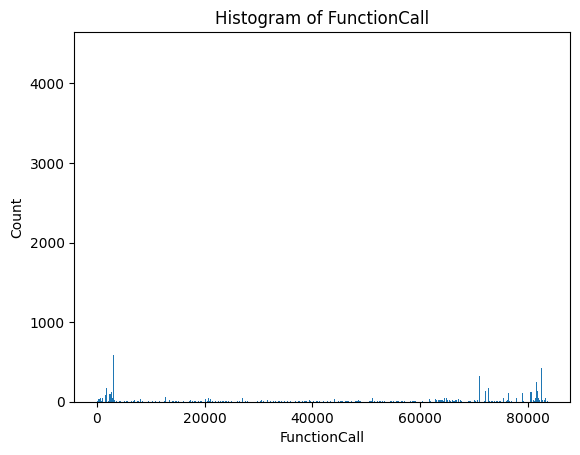

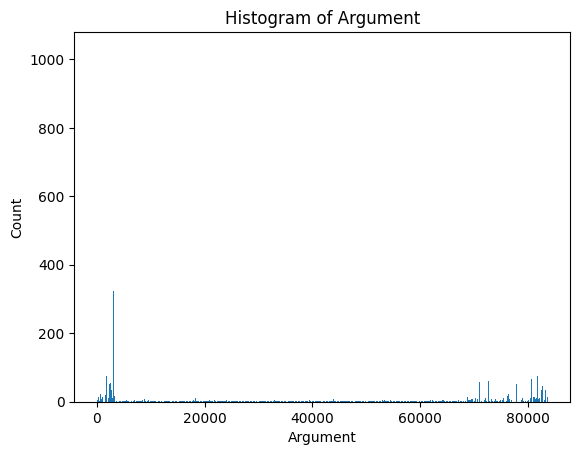

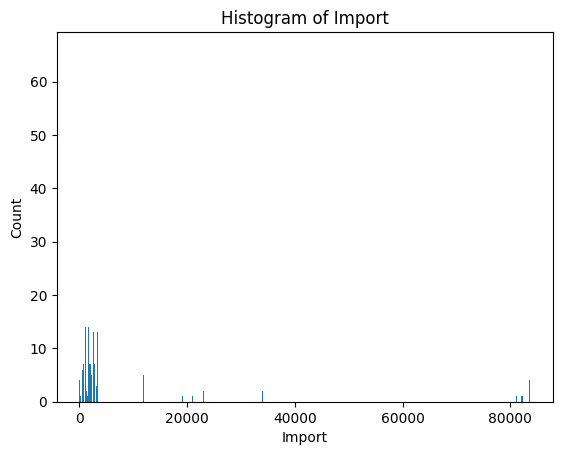

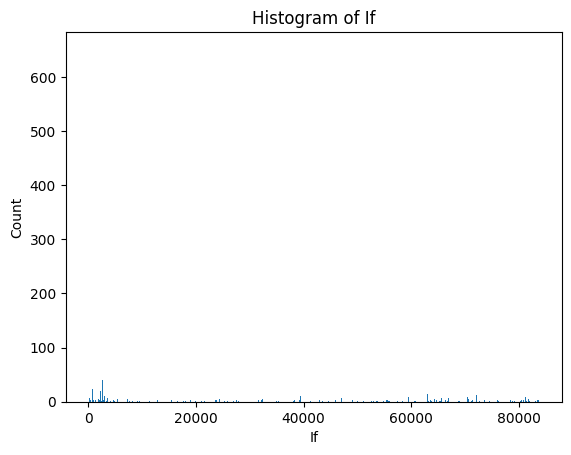

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105812bd0>>
Traceback (most recent call last):
  File "/Users/hk3user/.pyenv/versions/3.12.1/envs/pred_cst/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [31]:
import matplotlib.pyplot as plt
index = [i for i in range(df.shape[0])]
df = df.with_columns(pl.Series(name="index", values=index))
for col in df.columns:
    if col in ['code_token_len', 'cst_tree_token_len']:
        continue

    if isinstance(df[col].dtype, pl.Int64):

        
        # Create a bar histogram
        plt.figure()
        plt.bar( df['index'],df[col])
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.show()